In [25]:
# %%
"""
# NMME Temperature Observations to Avoid Loggerheads (TOTAL)
 
The script calculate the TOTAL value from the start of the nmme 1991 based on 
Brodie et al., [2023]

Using NMME model hindcast and forecast obtained from 
http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/
with variable SST

"""


# %%
# start a local cluster
import json
import subprocess
from datetime import date
import warnings
import numpy as np
import xarray as xr
from dask.distributed import Client
from nmme_download import iri_nmme_models
from nmme_hci_climo_threshold import read_marine_index_mask
from nmme_monthly_mhw import read_nmme_onlist
from nmme_hci_monthly import output_format

warnings.simplefilter("ignore")

if __name__ == "__main__":

    warnings.filterwarnings("ignore")

    ### open local cluster
    client = Client(processes=False)
    print(client)
    print(client.cluster.dashboard_link)

    ###### Setting ######
    # specify date
    today = date.today()
    # setup the new output file name (same as date of download)
    dateform = today.strftime("%y_%m_%d")

    # directory where new simulation (inputs) and mhw forecast (outputs) is located
    BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'

    # directory where sst threshold/climatology/trend (inputs) is located
    PREDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

    # directory where nmme mhw probability is located
    OUTDIR = '/Datasets.private/marinehw/nmme_mhw_prob/'

    # directory where the marine index mask is located
    MASKDIR = '/Datasets.private/marinehw/nmme_marine_index_mask/'

    # output filename date, MHW prediction generated date
    date = dateform

    # used model list
    with open('model_use_list.json','r',encoding='utf-8') as f:
        json_dict = json.load(f)
    model_use_list = json_dict['model_use_list']

    dict_model = iri_nmme_models()
    avai_model_list = list(dict_model.keys())

    ################################## Main program start #####################################

    dict_da = read_nmme_onlist(model_use_list,avai_model_list,BASEDIR,PREDIR,start_year=2023,lazy=False)

    ds_mask = read_marine_index_mask(MASKDIR)


   

<Client: 'inproc://10.173.16.4/2624940/27' processes=1 threads=96, memory=0.98 TiB>
http://10.173.16.4:33035/status
------------
CanCM4i-IC3
------------
reading data
------------
GEM5-NEMO
------------
reading data
------------
GFDL-SPEAR-regridded
------------
reading data
variable name convert from sst_regridded to sst
------------
NASA-GEOSS2S
------------
reading data
------------
COLA-RSMAS-CCSM4
------------
reading data
------------
COLA-RSMAS-CESM1
------------
reading data
------------
NCEP-CFSv2
------------
reading data


In [27]:
da_total_identified_list = []
da_total_all_list = []
model_use_list = ['CanCM4i-IC3']
for nmodel,model in enumerate(model_use_list):
    if model in avai_model_list:
        threshold_file = f'{PREDIR}{model}_climo_threshold_total.nc'

        print('------------')
        print(model,' TOTAL detection...')
        print('------------')

        # read threshold (1991-2020)
        da_threshold = xr.open_dataset(
            threshold_file,
            chunks={'S':1,'L':1}
        )['total_threshold']

        da_ssta = ds_mask['TOTAL']*(
            dict_da['da_model_list'][nmodel].groupby('S.month')
            -dict_da['da_climo_list'][nmodel]
        )
        # calculate area weight
        weights = np.cos(np.deg2rad(da_ssta.Y))
        weights.name = "weights"
        # calculate area weighted mean
        da_ssta_areamean = da_ssta.weighted(weights).mean(dim=["X","Y"])

        # calculate the 6-month rolling mean of the previous six month
        da_total = da_ssta_areamean.rolling(S=6, center=False).mean()

        # the rolling mean of six month is put in the last month of the six
        #  shift 1 is needed to let the rolling mean represent the monthly
        #  value the is 1 month after the six month window
        da_total = da_total.shift(S=1).persist()

        print('calculating TOTAL')
        da_total_identified = da_total.where(da_total.groupby('S.month')>=da_threshold)
        da_total_identified = (
            da_total_identified
            .where(da_total_identified.isnull(),other=1)
            .sum(dim=['M'],skipna=True)
        ).compute()
        da_total_all = (
            da_total
            .where(da_total.isnull(),other=1)
            .sum(dim=['M'],skipna=True)
        ).compute()
        da_total_identified_list.append(da_total_identified)
        da_total_all_list.append(da_total_all)

        del da_total

# total identified events higher than threshold (all ensemble and models)
da_total_identified_concat = xr.concat(da_total_identified_list,dim='model',join='outer')
da_total_identified_concat_summodels = (
    da_total_identified_concat.sum(dim='model',skipna=True)
).compute()

# total month (all ensemble and models)
da_total_all_concat = xr.concat(da_total_all_list,dim='model',join='outer')
da_total_all_concat_summodels = (
    da_total_all_concat.sum(dim='model',skipna=True)
).compute()

ds_total_prob = xr.Dataset()
notes = 'TOTAL probability derived from '
ds_total_prob.attrs['title'] = [f'{notes} {model}' for model in model_use_list]
ds_total_prob.attrs['comment'] = 'Derived at NOAA Physical Science Laboratory'
ds_total_prob.attrs['reference'] = 'Brodie et al., 2023, https://doi.org/10.1038/s41467-023-43188-0'
ds_total_prob['total_probability'] = (
    da_total_identified_concat_summodels/da_total_all_concat_summodels
)




------------
CanCM4i-IC3  TOTAL detection...
------------
calculating TOTAL


2024-06-06 15:30:56,083 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


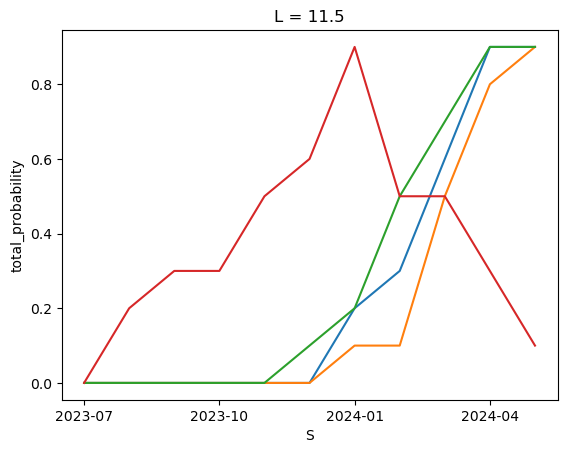

In [32]:
ds_total_prob.isel(L=2).total_probability.plot()
ds_total_prob.isel(L=5).total_probability.plot()
ds_total_prob.isel(L=6).total_probability.plot()
ds_total_prob.isel(L=11).total_probability.plot()


In [21]:
da_total = da_ssta_areamean.rolling(S=6, center=False).mean()


In [20]:
da_ssta_areamean

<xarray.DataArray (S: 5, M: 10, L: 12)>
array([[[ 1.01359141e+00,  8.74920011e-01,  8.17085445e-01,
          3.50872129e-01,  1.96287960e-01, -1.85018480e-01,
          5.62288225e-01,  4.45939004e-01,  2.73447126e-01,
          5.24095118e-01,  6.21813476e-01,  7.51160800e-01],
        [ 1.29555905e+00,  1.37754381e+00,  1.24846864e+00,
          1.52281046e+00,  1.38974965e+00,  2.54945457e-01,
          1.09664750e+00,  1.02572966e+00,  8.85362178e-02,
          5.04400969e-01,  1.61333227e+00,  8.01956773e-01],
        [ 8.37769866e-01,  4.64344829e-01,  5.42046905e-01,
          1.01290250e+00,  1.25781989e+00,  3.92095476e-01,
          3.03049028e-01,  1.42592728e-01,  6.62998036e-02,
         -2.00566337e-01, -1.08797586e+00, -1.44862831e+00],
        [ 8.10817420e-01,  4.39676523e-01, -2.97961626e-02,
          9.14710239e-02, -3.86281103e-01, -6.75110996e-01,
         -5.98818474e-02,  1.11699373e-01,  6.43740416e-01,
          1.18250139e-01, -1.03423715e+00, -1.05965257e+00],
        [ 1.10554230e+00,  1.10120261e+00,  1.21110058e+00,
          1.09748316e+00,  6.09771967e-01,  4.67962652e-01,
          4.26933289e-01,  3.35373133e-01,  2.73979783e-01,
          1.27605164e+00,  3.83455038e-01, -9.60731059e-02],
...
         -7.94799849e-02,  2.47022912e-01,  1.66183770e-01,
         -8.98417771e-01, -5.82319975e-01, -8.73295486e-01,
         -6.55888736e-01, -3.78188521e-01, -3.21174532e-01],
        [-2.97134053e-02,  1.03334069e+00,  1.85368374e-01,
         -1.09794155e-01,  3.50372970e-01, -3.16078097e-01,
         -5.69346666e-01, -2.86967754e-01, -8.60837549e-02,
          3.83506119e-01,  1.02168036e+00,  4.95815605e-01],
        [-8.86852294e-02,  3.31344455e-01, -3.96318406e-01,
         -1.92216292e-01, -3.20514232e-01, -3.54849547e-01,
          3.55453223e-01, -9.86513570e-02,  6.34071529e-02,
          3.99303705e-01,  4.47655797e-01, -4.57416862e-01],
        [ 2.21551299e-01,  3.79451722e-01, -1.57760695e-01,
          6.99519292e-02,  4.49816853e-01,  4.46122020e-01,
         -6.21234298e-01, -8.69684994e-01,  3.25601990e-03,
          8.46768990e-02,  3.89611810e-01,  2.85841286e-01],
        [ 5.99366128e-01, -1.27821416e-01,  4.45323676e-01,
          6.17602527e-01,  5.02881944e-01,  3.13066512e-01,
         -2.24065125e-01, -6.25862956e-01, -7.01140285e-01,
         -7.07235157e-01, -3.82182389e-01,  2.27643684e-01]]],
      dtype=float32)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) object 2024-01-01 00:00:00 ... 2024-05-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
    month    (S) int64 1 2 3 4 5

In [22]:
da_total

<xarray.DataArray (S: 5, M: 10, L: 12)>
array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
...
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]],
      dtype=float32)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) object 2024-01-01 00:00:00 ... 2024-05-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
    month    (S) int64 1 2 3 4 5